In [236]:
import keras
from keras.models import *
from keras.layers import *
from keras.regularizers import *
import sklearn
import tensorflow as tf
import keras.optimizers
import sqlite3
import datetime
import math
import seaborn as sns
import numpy as np
import pandas as pd

!pip install livelossplot
from livelossplot.keras import PlotLossesCallback

In [237]:
conn = sqlite3.connect('database.db')

In [238]:
raw_data = [i for i in conn.execute("SELECT lat, lon, time FROM simulated")]
print(len(raw_data))
print(raw_data[0])

1930001
(40.44245004375, -79.94473601017812, '2021-10-01 00:08:00')


In [244]:
def parse_time(time):
  time = time.split(".")[0]
  return datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S").timestamp()

def to_time(sample):
  return sample[2]

start_time = min(raw_data, key=lambda x: parse_time(to_time(x)))
end_time = max(raw_data, key=lambda x: parse_time(to_time(x)))

start_time = parse_time(to_time(start_time))
end_time = parse_time(to_time(end_time))

BUCKETS = 1000

processed = []
for i in range(BUCKETS):
  processed.append([])

for sample in raw_data:
  curr_time = parse_time(to_time(sample))

  curr_idx = math.floor((curr_time - start_time - 1) * BUCKETS / (end_time - start_time))

  processed[curr_idx].append(sample)

In [245]:
def dist(p1, p2):
  x = p1[0] - p2[0]
  y = p1[1] - p2[1]

  return math.sqrt(x**2 + y**2)

def clean_processed(data):
  cleaned = []
  for point in data:
    if cleaned:
      min_pt = min(cleaned, key=lambda x: dist(point, x))
    
      if dist(min_pt, point) > 0.0002:
        cleaned.append(point)
    else:
      cleaned.append(point)

  return cleaned


print(len(processed[0]))
print(len(clean_processed(processed[0])))

9
4


In [246]:
pd.DataFrame(data={
  "X": [1,2,3],
  "Y": [5,6,7]  
})

,X,Y
0,1,5
1,2,6
2,3,7


In [247]:
def extract_points(key_points, data):
  ret = []
  for point in data:
    min_point = min(key_points, key=lambda x: dist(x, point))

    if dist(min_point, point) < 0.002:
      ret.append(point)

  return ret


[40.441630003447706, 40.441407902726205, 40.44181660625, 40.441836109926044]
[40.441630003447706, 40.44181660625, 40.441836109926044]


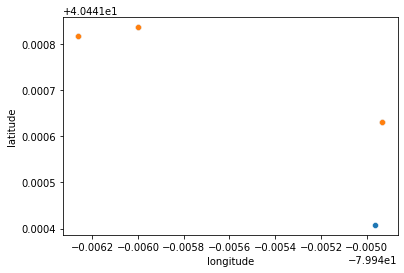

In [248]:
def plot(data):
  x = [a[0] for a in data]
  y = [a[1] for a in data]

  print(x)

  sns.scatterplot(data=pd.DataFrame(data={
      "latitude": x,
      "longitude": y
  }), x="longitude", y="latitude")


#plot(processed[0])
plot(clean_processed(processed[0]))

key_points = [
    (40.443428578, -79.94563020846905),
    (40.44301507, -79.94203969055374),
    (40.442504266, -79.9400592703583),
    (40.443939382, -79.94218459934854),
    (40.441470496, -79.94208799348534),
    (40.445252878, -79.94324726384365)
]
plot(extract_points(key_points, clean_processed(processed[0])))

In [249]:
processed[0][0]

(40.441630003447706, -79.94493132726592, '2021-10-01 00:00:17.174412')

In [250]:
dist_cutoff = 0.001

def extract_features_bucket(keypoints, points_in_bucket):
  result = []
  for i in range(len(keypoints)):
    sum = 0
    cur_keypoint = keypoints[i]
    for point in points_in_bucket:
      if(dist(cur_keypoint, point) < dist_cutoff):
        sum += 1
    result.append(sum)
  return result

def extract_features_total(keypoints, points):
  result = []
  for points_in_bucket in points:
    result.append(extract_features_bucket(keypoints, points_in_bucket))
  df = pd.DataFrame(result, columns = ["hunan", "entropy", "resnick", "abp", "exchange", "underground"])
  return df

features = extract_features_total(key_points, processed).to_numpy()
features = features / features.max()

In [251]:
features

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00078064, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00468384, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00468384, 0.        , 0.00312256, 0.        ,
        0.        ],
       [0.        , 0.00468384, 0.        , 0.00156128, 0.        ,
        0.        ],
       [0.        , 0.00546448, 0.        , 0.00078064, 0.        ,
        0.        ]])

In [252]:
X_data = []
y_data = []

TIME_INTERVAL = 50
for i in range(BUCKETS - TIME_INTERVAL - 1):
  X_data.append(features[i:i+TIME_INTERVAL])
  y_data.append(features[i + TIME_INTERVAL])

X_data = np.array(X_data)
y_data = np.array(y_data)

In [253]:
X_data[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00078064, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00468384, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00312256, 0.00078064, 0.00546448, 0.00078064, 0.        ,
        0.        ],
       [0.0117096 , 0.00468384, 0.01014832, 0.00546448, 0.        ,
        0.        ],
       [0.01405152, 0.0039032 , 0.01014832, 0.0039032 , 0.        ,
        0.        ],
       [0.02029664, 0.00468384, 0.00936768, 0.00468384, 0.        ,
        0.        ],
       [0.02576112, 0.00546448, 0.01092896, 0.00546448, 0.        ,
        0.        ],
       [0.02576112, 0.00546448, 0.01405152, 0.00546448, 0.        ,
        0.        ],
       [0.03669009, 0.00624512, 0.01405152, 0.00624512, 0.        ,
        0.        ],
       [0.03747073, 0.01014832, 0.01249024, 0.01014832, 0.        ,
        0.        ],
       [0.03747073, 0

In [261]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)

In [264]:
hidden_dim = 16
num_classes = y_data.shape[1]

model = keras.Sequential()
model.add(GRU(hidden_dim, return_sequences=False, input_shape=X_data.shape[1:])) #, kernel_regularizer=L1L2(l1=0.02, l2=0.02)))
model.add(Dense(num_classes, activation="sigmoid"))

model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001))

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_14 (GRU)                 (None, 16)                1152      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 102       
Total params: 1,254
Trainable params: 1,254
Non-trainable params: 0
_________________________________________________________________


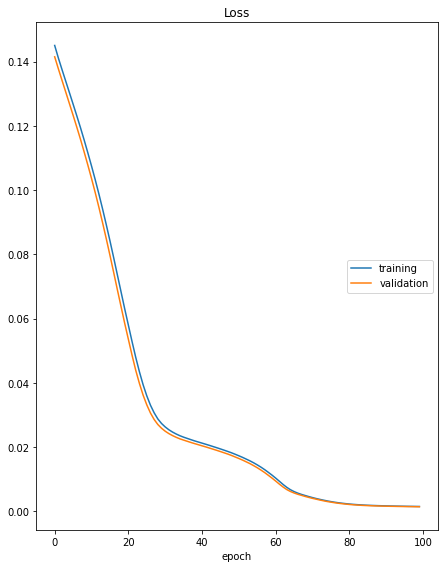

Loss
	training         	 (min:    0.002, max:    0.145, cur:    0.002)
	validation       	 (min:    0.001, max:    0.142, cur:    0.001)


In [265]:
history = model.fit(X_train, y_train,
 batch_size=16,
 epochs=100,
 callbacks=[PlotLossesCallback()],
 validation_data=(X_test, y_test)
)

1634252755.0